# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #3
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Thursday, Febrary 16th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [46]:
import numpy as np
import pandas as pd
from scipy import stats 
import time
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Optimization via Descent

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.


### Table of Contents

1. [Visualizing Our Loss Function](#viz)

2. [Review of Optimization Via Gradient Descent](#review_grad)

3. [Review of Optimization Via Gradient Descent & Mini-Batch Descent](#review_approx)

4. [Implementation: Gradient Descent](#implement_grad)

5. [Implementation: Stochastic Gradient Descent](#implement_rand)

6. [Comparison: Gradient Descent vs Stochastic Gradient Descent](#compare)


### Part A
- Visually verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized for the given data.
- Implement gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.
- Implement stochastic gradient descent for minimizing $L$ for the given data, using the learning rate of 0.001.

**Solutions:**

<a id='viz'></a>
### Visualizing Our Loss Function
Given our loss function $L(x, y, \lambda_1, \lambda_2)$ at the coordinate $(x, y)$ and for the set of parameter settings $(\lambda_1, \lambda_2)$, the ***total loss*** over the entire set of coordinates in the data is
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= \sum_{i=1}^N\left[0.000045\lambda_2^2 y_i - 0.000098\lambda_1^2 x_i + 0.003926\lambda_1 x_i\exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\right]\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
\end{aligned}
where $N$ is total number of coordinates in our data set. Now, since the pipes are being laid down in a particular geometric pattern, namely along a hyperbola described by $y^2 - x^2 = -0.1$, we can further simplify the above as:
\begin{aligned}
\mathrm{Total Loss} = \sum_{i=1}^N L(x_i, y_i, \lambda_1, \lambda_2) &= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(y_i^2 - x_i^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \sum_{i=1}^N x_i \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\\
&= 0.000045\lambda_2^2 \sum_{i=1}^N y_i - 0.000098\lambda_1^2 \sum_{i=1}^N x_i + 0.003926\lambda_1 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^N x_i.
\end{aligned}
In `python`, we would write the above as
```
total_loss = 0.000045 * lambda_2**2 * y.sum() - 0.000098 * lambda_1**2 * x.sum() + 0.003926 * lambda_1 * x.sum() * np.exp(-0.1 * (lambda_1**2 + lambda_2**2))
```

Now, our task can be stated in a straightforward fashion: we wish to find values of $\lambda_1$ and $\lambda_2$ such that the total loss is minized for our set of coordinates.

> 
**A Note on Terminology:**
In optimization (the subfield of mathematics/computer science which studies methods for finding optimal solutions to mathematical systems and models), the terms "loss function", "cost funciton", "objective function" are often used interchageably. Of these terms, "objective function" is the most general. An objective function is a mathematical expression describing the perceived value of a particular set of outcomes of circumstances (e.g. an objective function can describe your expected income given your work experience and eduction, the expected duration of a marriage given the length and quality of conflicts, the revenue of a company given the quantity of goods produced and the unit retail price, etc). The chief task in optimization is to maximize or minize your objective function.

> 
A "loss function" or "cost function" is a specific type of objective function that you mean to *minimize* (e.g. you'd want to minimize loss or cost functions like poverty levels or the lengths of winter months). While functions you'd mean to maximize are typically called "utility functions" or "fitness functions" (e.g. you'd like to maximize revenue, expected income etc).

> 
In gradient ***descent*** we seek the minimum of objective functions by iteratively descreasing the objective using the gradient. Thus, for gradient descent our objective functions are called "loss functions" or "cost functions".

Now before running ***any*** optimization algorithms on our objective function, we must do some exploration of our function, either by analysis or visualization! This step is important for the following reasons:

1. iteratively following the gradient (the direction of maximum increase or decrease in the objective function at a point) ***does not*** guarantee that you will end in a global maximum or minimum. In fact, if your function has local maxima, local minima or saddle points (at which the gradient is zero - these are called stationary points), your gradient descent may very well become trapped at these points. In this sense, where you initialize your gradient descent algorithm becomes very important. Some initializations will lead you to an undesirable stationary point, while others will lead you to your global maximum or minimum. 

2. analytical, numerical or visual explorations of your function can help you determine appropriate step sizes for your descent algorithms (would $\eta = 0.001$ be appropriate or $\eta=1000$?).



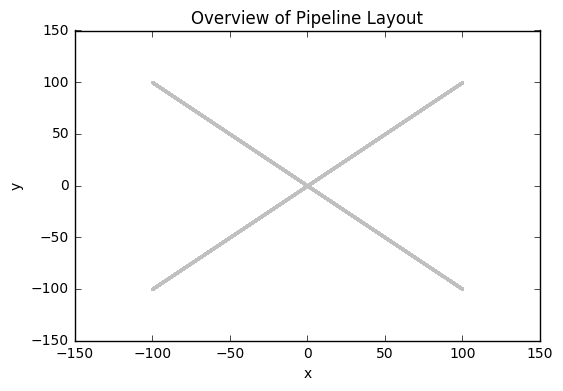

In [11]:
#Visualization of the data - what does the pipeline look like?
x, y = np.genfromtxt('HW3_data.csv', delimiter=',')

plt.scatter(x, y, color='silver', s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Overview of Pipeline Layout')
plt.show()

In [44]:
x_sum = x.sum()
y_sum = y.sum()
N = len(x)

#Total loss
L = lambda l1, l2, x, y: 0.000045 * l2**2 * y.sum() - 0.000098 * l1**2 * x.sum() + 0.003926 * x.sum() * l1 * np.exp(-0.1 * (l1**2 + l2**2))

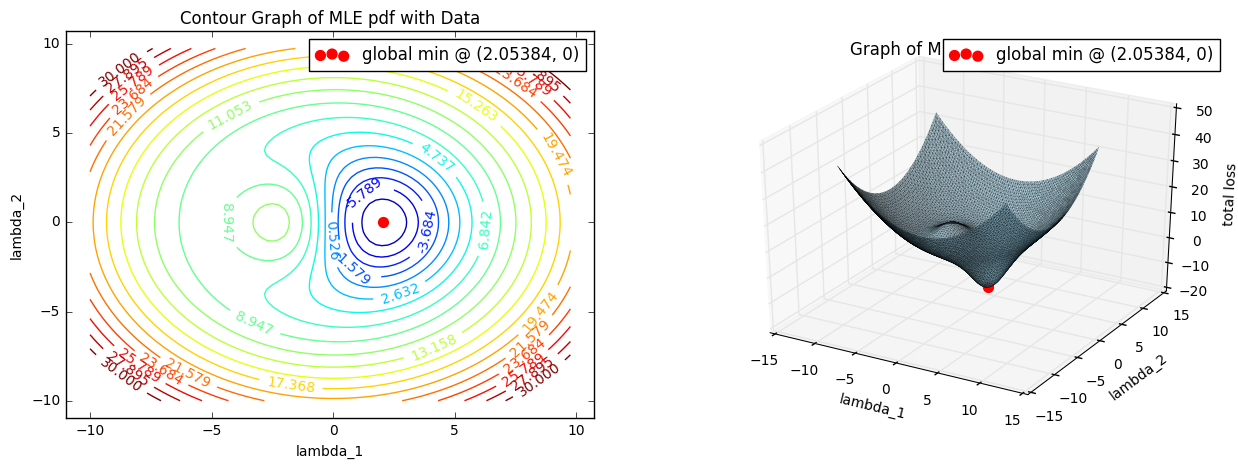

In [39]:
#cover the domain of the pdf with a grid and get the coordinates of the grid vertices
delta = 0.25
l1 = np.arange(-10, 10, delta)
l2 = np.arange(-10, 10, delta)
l1, l2 = np.meshgrid(l1, l2)

loss = L(l1, l2, x, y)

fig = plt.figure(figsize=(15, 5))


#plot contour map of pdf with data in R^2 (Cartesian plane)
ax1 = fig.add_subplot(121) 
contour = ax1.contour(l1, l2, loss, levels=np.linspace(-10, 30, 20))
ax1.scatter([2.05384], [0], color='red', s=50, label='global min @ (2.05384, 0)')
ax1.clabel(contour, inline=1, fontsize=10)
ax1.set_title('Contour Graph of MLE pdf with Data')
ax1.set_xlabel('lambda_1')
ax1.set_ylabel('lambda_2')
ax1.legend(loc='best')

#plot 3D suface of pdf in R^3, with data in R^2
ax2 = fig.add_subplot(122, projection='3d') 
ax2.plot_trisurf(l1.flatten(), l2.flatten(), loss.flatten(), linewidth=0.2, antialiased=True, color='skyblue', alpha=0.5)
ax2.scatter([2.05384], [0], [L(2.05384, 0, x, y)], color='red', s=50, label='global min @ (2.05384, 0)')
ax2.set_xlabel('lambda_1')
ax2.set_ylabel('lambda_2')
ax2.set_zlabel('total loss')
ax2.set_title('Graph of MLE pdf with Data')
ax2.legend(loc='best')

plt.show()

From the above, we see that the total loss is minimized at $(\lambda_1, \lambda_2) = (2.05384, 0)$. We leave to you to find the other points of interest in the parameter space (it is important that you do!). 

In [43]:
print 'The minumum total cost:', L(2.05384, 0, x, y)

The minumum total cost: -9.9341040253


<a id="review_grad"></a>
### Review of Optimization Via Gradient Descent
(***The following reviews the basic concepts behind the gradient descent algorithm, in response to questions during office hours. You may wish to skip directly to implementation if you are solid on the theoretical background behind these methods.***)

The intuition behind various flavours of gradient descent is as follows:

0. we imagine we are walking on the graph of our objective function. In our case, our objective function is a function of two real variables and so its graph is a surface in $\mathbb{R}^3$. In this analogy, the global minimum of the function occurs at the bottom of the steepest valley on this surface (see upper right graph).

1. we want to descent (climb downhill towards the bottom of steepest valley) as quickly as possible. So, after taking each step, we take the gradient of the objective function at our current position,
$$
\nabla Total Loss (\lambda^{current}_1, \lambda^{current}_2) = \left\langle\frac{\partial Total Loss}{\partial \lambda_1}, \frac{\partial Total Loss}{\partial \lambda_2} \right\rangle
$$
The gradient is a vector pointing towards the direction of steepest ascent (the fastest way up). Therefore, the negative of the gradient is a vector pointing towards the direction of steepest descent (the fastest way down).
<img src='grad.pdf'>
The gradient, in our case, contains two components: an update in the $\lambda_1$ direction ($\frac{\partial Total Loss}{\partial \lambda_1}$ is an instruction to move $\frac{\partial Total Loss}{\partial \lambda_1}$ units from your current position in the $\lambda_1$ direction), and an update in the $\lambda_2$ direction. However, we may only wish to take a fraction, $\eta$, of a step in the direction of the negative gradient. Thus, our new position can be expressed as:
\begin{aligned}
\langle\lambda^{new}_1, \lambda^{new}_2\rangle &= \langle\lambda^{old}_1, \lambda^{old}_2\rangle - \eta\left\langle\frac{\partial Total Loss}{\partial \lambda_1}, \frac{\partial Total Loss}{\partial \lambda_2} \right\rangle\\
&= \left\langle \lambda^{old}_1 - \eta \frac{\partial Total Loss}{\partial \lambda_1}, \lambda^{old}_2 - \eta \frac{\partial Total Loss}{\partial \lambda_2}\right\rangle
\end{aligned}

2. we repeat the process of stepping in the negative gradient direction and computing a new gradient until we are no longer make significant progress (i.e. we are close to an idea solution, or the changes we make in $\lambda_1$ and $\lambda_2$ after each step are miniscule).

The gradient descent algorithm pseudo-code:
```
Algorithm 1:

start at random place: lambdas = [random_value_1, random_value_1]
until (stopping condition satisfied):
    compute gradient: gradient = gradient_function(lambdas, data)
    take a step in the negative gradient direction: 
    lambdas = lambdas - eta * gradient
```

<a id="review_approx"></a>
### Review of Optimization Via Gradient Descent & Mini-Batch Descent
(***The following reviews the basic concepts behind stochastic and mini-batch gradient descent algorithms, in response to questions during office hours. You may wish to skip directly to implementation if you are solid on the theoretical background behind these methods.***)

Note that in the gradient descent algorithm, computing the gradient $\frac{\partial Total Loss}{\partial \lambda_i}$ requires us to compute $\sum_{i=1}^N x_i$ and $\sum_{i=1}^N y_i$ (see definition of the total loss function. Suming up the $x$, $y$ values over the entire dataset is trivial when the dataset is small, but these operations become infeasible or undesirable when the data is truly large (cannot be physically stored on a single machine, for example). In this case, we ***approximate*** the true gradient of the loss function $Total Loss$ with the gradient of a approximate loss function $\widetilde{Total Loss}$, where, after permuting our data, 
$$
Total Loss \approx \widetilde{Total Loss} = 0.000045\lambda_2^2 \sum_{i=1}^\tilde{N} y_i - 0.000098\lambda_1^2 \sum_{i=1}^\tilde{N} x_i + 0.003926\lambda_1 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^\tilde{N} x_i.
$$
That is, $\widetilde{Total Loss}$ is just $Total Loss$ evaluated at a random selection of a small *subset* of the data. 

In this version of events, we seek the global minimum by following approximations, $\nabla \widetilde{Total Loss}$, of the true gradient, $\nabla Total Loss$. 

Our approximate gradient descent algorithm is:
```
Algorithm 2:

start at random place: lambdas = [random_value_1, random_value_1]
until (stopping condition satisfied):
    randomly select a subset of the data: data_subset
    compute approximate gradient: approx_grad = gradient_function(lambdas, data_subset)
    take a step in the negative approximate gradient direction: 
    lambdas = lambdas - eta * approx_grad
```
A couple of important observations:

1. When $\tilde{N} = N$ then the "approximate" gradient descent algorithm is just regular old gradient descent. 

2. When $\tilde{N} = 1$ then the "approximate" gradient descent algorithm is called ***stochastic gradient descent***.

3. When $\tilde{N} < N$ then the "approximate" gradient descent algorithm is called ***mini-batch descent***.

So why doesn't the Stochastic Gradient Descent algorithm presented in class look like this? Well, the problem with randomly picking a single data point to compute your approximate gradient can be illustrated by the following example:

> **Example:** suppose your loss function $L$ is defined as 
$$
L = \text{[cost of flood insurance]} + \text{[cost of uninsured flood damage]} * \text{[scale of damage given precipitation level]}
$$
The data you've been given is a list of daily precipitation levels in the Sacramento Valley of California. Your goal is to determine the type of flood insurance to buy in order to minimize the loss function $L$. In this area, you would find that around 98% of the days in a year will have zero to low levels of precipitation, while 2% of the days will have catastrophic levels of precipitation. If you were to determine the most cost saving type of flood insurance to buy by randomly sampling days from your dataset, you will surely be mislead into believing that no flood insurance is needed. On the other hand, if you totaled or averaged the cost over the entire dataset, you would come to a very different conclusion.

The lesson is that if we are to use stochastic gradient descent or mini-batch descent, we need to ensure that our algorithm iterates through the entire dataset often enough. Thus, we modify Algorithm 2 as follows:
```
start at random place: lambdas = [random_value_1, random_value_1]
until (stopping condition satisfied):
    randomly shuffle the data
    divide the data into segments, with N_tilde elements in each segment
    for each data_segment do:
        compute approximate gradient: approx_grad = gradient_function(lambdas, data_segment)
        take a step in the negative approximate gradient direction: 
        lambdas = lambdas - eta * approx_grad
```
Again, when $\tilde{N} = 1$, this algorithm is precisely stochastic gradient descent; when $\tilde{N} < N$, this algorithm is mini-batch descent.

<a id="implement_grad"></a>
### Implementation: Gradient Descent

We first calculate the gradient of our total loss function,
\begin{aligned}
\frac{\partial TotalLoss}{\partial \lambda_1} =&  -2 * 0.000098\lambda_1 \sum_{i=1}^{N} x_i + 0.003926 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i \\
& - 0.1 * 0.003926 * 2 * \lambda_1^2 * \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i\\
\frac{\partial TotalLoss}{\partial \lambda_2} =&\,  2 * 0.000045\lambda_2^2 \sum_{i=1}^{N} y_i - 0.1 * 2 *  0.003926\lambda_1  \lambda_2 \exp\left\{\left(-0.1\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}\sum_{i=1}^{N} x_i.\\
\nabla TotalLoss =&\, \left\langle\frac{\partial TotalLoss}{\partial \lambda_1}, \frac{\partial TotalLoss}{\partial \lambda_2} \right\rangle .
\end{aligned}

In [49]:
#The gradient of the total loss function
grad = lambda l1, l2, x, y: np.array([-0.000098 * 2 * l1 * x.sum() 
                                      + 0.003926 *  x.sum() * np.exp(-0.1 * (l1**2 + l2**2)) 
                                      - 0.003926 * 2 * 0.1 *  x.sum() * l1**2 * np.exp(-0.1 * (l1**2 + l2**2)), 
                                      2 * 0.000045 * l2 * y.sum() 
                                      - 0.1 * 2* 0.003926 *  x.sum() * l1 * l2 * np.exp(-0.1 * (l1**2 + l2**2))])

A note on the correct loss function to use:

> **Total Loss or Average Loss?** If we're just interested in minimizing the loss, minimizing total loss is equivalent to minimizing average loss. This is because
$$
Average Loss = \frac{1}{N} TotalLoss
$$
Clearly, since $N$ is a constant, when total loss is minimized then average loss is minimized (and vice versa). However, if we are interested in comparing the performance of gradient descent with that of stochastic gradient descent, we need to find a loss function that facilitates a fair comparison. 

> If we use the total loss for both descent algorithm, then the gradient for gradient descent will tend to be much larger (since in gradient descent, we sum over the entire dataset to compute the gradient, whereas in stochastic gradient descent, we use only one pair of coordinates to compute the gradient). Larger gradients will tend to yield larger steps in our descent, which, in turn, will tend to result in faster convergence. 

> To be fair, we will use the ***average loss function*** for both gradient descent and stochastic gradient descent. This make sense semantically as well, the loss funtion averaged over the entire data set is the expected loss for a single coordinate, whereas evaluating the loss function at a random coordinate is a way of approximating the expected loss for a single coordinate. 

> Coding wise, we just need to multiply the total cost function and the gradient function we've defined by 1/N to turn them into averages.

A note on the correct stopping condition to use:

> **Average/Total loss or lambdas?** In this problem, we know the precise location of the global minimum: (2.05384, 0), and we know the minimum total cost: -9.9341040253. So should we stop when we are sufficiently close to the optimal parameters, $(2.05384, 0)$, or should we stop when we are sufficiently close to the minimum total cost? Well, the difference is not significant and in general you can choose to use either as your stopping condition. However, since evaluating the cost at each step of the gradient descent (which involves suming over your entire dataset) is one extra computation expense, it might be more efficient to use distance to the optimal parameters as your stopping condition. 

> That is, we stop our descent when
$$
\| \langle lambda_1,  lambda_2\rangle - \langle 2.05384, 0 \rangle \|_2 < 1e^{-3}
$$
where $\| \cdot \|_2$ is the $\ell_2$ norm or the Euclidean distance.

In [67]:
#Gradient Descent
def gradient_descent(x, y, lambdas_init, init_shuffle=False, step_size=0.001, maxsteps=None, precision=1e-3, scaling=1.):
    
    lambdas = lambdas_init
    history = [lambdas] # to store all parameters
    counter = 0

    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]

    #Do descent while stopping condition not met
    while np.linalg.norm(history[-1] - np.array([2.05384, 0])) > precision:
        #get gradient of average loss function
        gradient = grad(lambdas[0], lambdas[1], x, y) * 1. / N
        #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
        #of course you can just directly adjust the stepsize
        lambdas = lambdas -  step_size * gradient * scaling 
        #add our new parameters to the history
        history.append(lambdas)
        #tick off one more step
        counter +=1
        
        #if we've hit maximum steps allowed, stop!
        if maxsteps is not None:
            if counter == maxsteps:
                break
        
    return history

time to compute one gradient:  0.000573873519897
how many iters:  43545
final cost: -9.93410274855
precision to actual param: 0.000999868898541


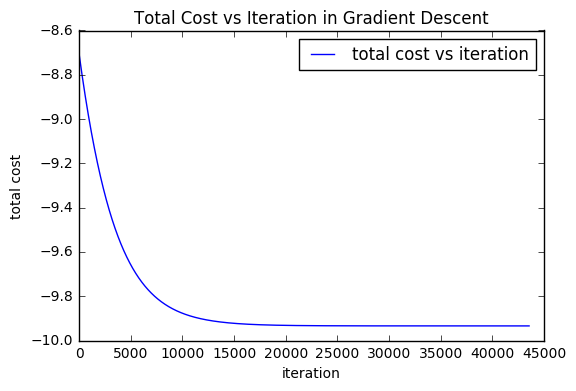

In [93]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x, y) * 1./len(x)
end = time.time() 

history = gradient_descent(x, y, lambdas_init, step_size=0.001, scaling=1000., maxsteps=100000)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)

print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final cost:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

plt.plot(range(len(costs)), costs, label='total cost vs iteration')
plt.xlabel('iteration')
plt.ylabel('total cost')
plt.title('Total Cost vs Iteration in Gradient Descent')
plt.legend(loc='best')
plt.show()

We see that we are within tolerance of our optimal parameters after 43,545 steps in the gradient descent algorithm. From the visualization of the total cost versus iteration, we see that initially we were making large updates to our parameters (the total cost was changing quickly), but towards the end the updates to our parameters became smaller and smaller (the total cost was not changing very much from iteration to iteration). This is expected, as the gradient around the global minimum in our case should be close to zero, resulting in very small step-sizes in our descent.

<a id="implement_rand"></a>
### Implementation: Stochastic Gradient Descent

The algorithm for Stochastic Gradient Descent is nearly identical to gradient descent, except for the fact that when we compute the gradient, we feed the gradient function a single coordinate rather than the entire dataset. Furthermore, we make multiple passes through the data, randomizing the dataset at the beginning each time.

In [133]:
#Stochastic Gradient Descent
def sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=1, precision=1e-3, scaling=1.):
    lambdas = lambdas_init
    history = [lambdas] # to store all thetas

    counter = 0
    epochs = 0
    i = 0 #index
        
    #if you want to shuffle the data before doing descent
    if init_shuffle:
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]    
    
    #run through the data in multiple passes
    for epoch in range(max_epochs):
        #for each data point, compute the gradient and make an update to our parameters
        print 'epoch: ', epoch 
        for i in range(N):
            #get gradient of average loss function
            gradient = grad(lambdas[0], lambdas[1], x[i], y[i])
            #take one step in the gradient direction, scaling is just a scaling factor that adjusts the stepsize
            #of course you can just directly adjust the stepsize
            lambdas = lambdas -  step_size * gradient * scaling 
            #add our new parameters to the history
            history.append(lambdas)   
            
            if np.linalg.norm(np.array(lambdas) - np.array([2.05384, 0])) < precision:
                return history, epoch
            elif np.any(np.isnan(lambdas)):
                return history[:-1], epoch
        
        #shuffle the data for the next pass thru
        shuffle = np.random.permutation(N)
        x = x[shuffle]
        y = y[shuffle]
    
    return history, max_epochs

epoch:  0
****************************
no initial random shuffling
****************************
time to compute one gradient:  0.000241994857788
how many iters:  15868
final loss: -9.93410285228
precision to actual param: 0.000958405055688


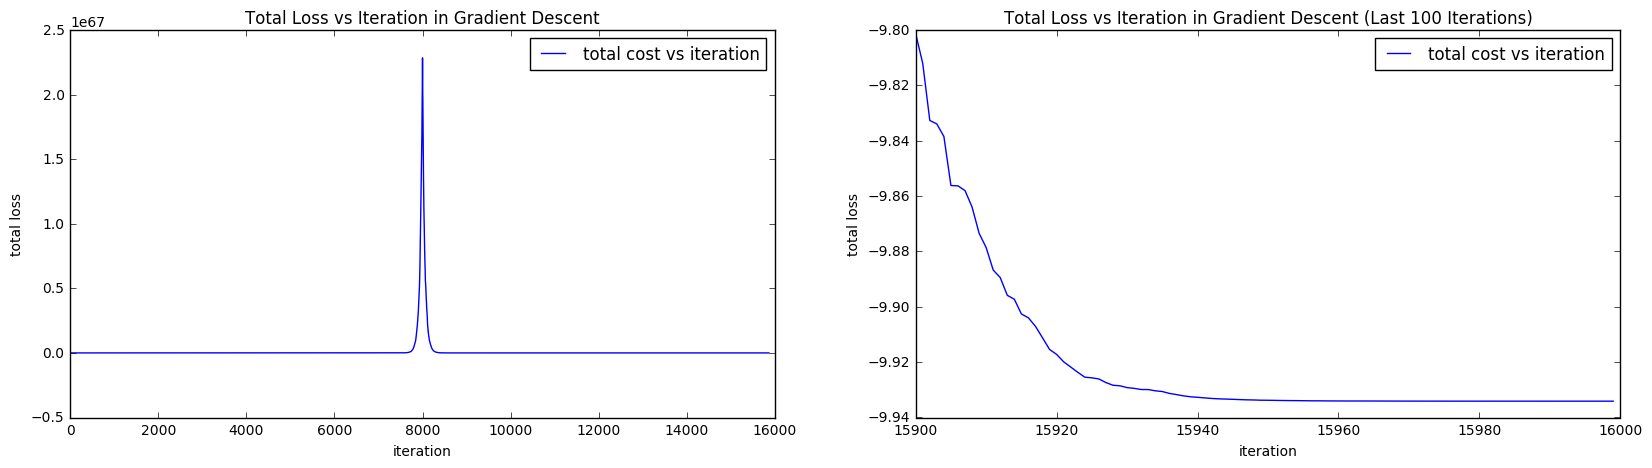

In [113]:
lambdas_init = [2, 1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.001, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'no initial random shuffling'
print '****************************'
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(np.arange(len(costs[-100:])) + N - 100, costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

We see that we are within tolerance of our optimal parameters after 15,868 steps (versus the 43,545 steps it takes gradient descent) in the stochastic gradient descent algorithm. From the visualization of the total loss versus iteration, we see that during our descent, we headed (around iteration number 8,000) in the direction which ***increased*** total cost! But how can this happen? 

Recall that in stochastic gradient descent, we are stepping in the direction that minimizes the loss function for just **one** data point rather than the direction that minimized the loss over the entire dataset. Clearly, pursuing local, short term gains does not lead you down the same path as pursuing global, long term gains. Thus, descending in the direction that descreases the loss for one data point can often lead to an increase the loss over the entire dataset.

Interestingly enough, although our total loss spiked around iteration 8,000, our stochastic gradient descent was able to find the global minimum in a shorter total number of iterations! That is, sometimes the quickest way down hill lies beyond a big climb!

In contrast, gradient descent is typically incapable of finding paths along which the total cost rises. That is, the total cost is expected to decrease form one iteration to the next.

epoch:  0
****************************
with initial random shuffling
****************************
time to compute one gradient:  0.000381946563721
how many iters:  1990
final loss: -9.93410280663
precision to actual param: 0.000976871030387


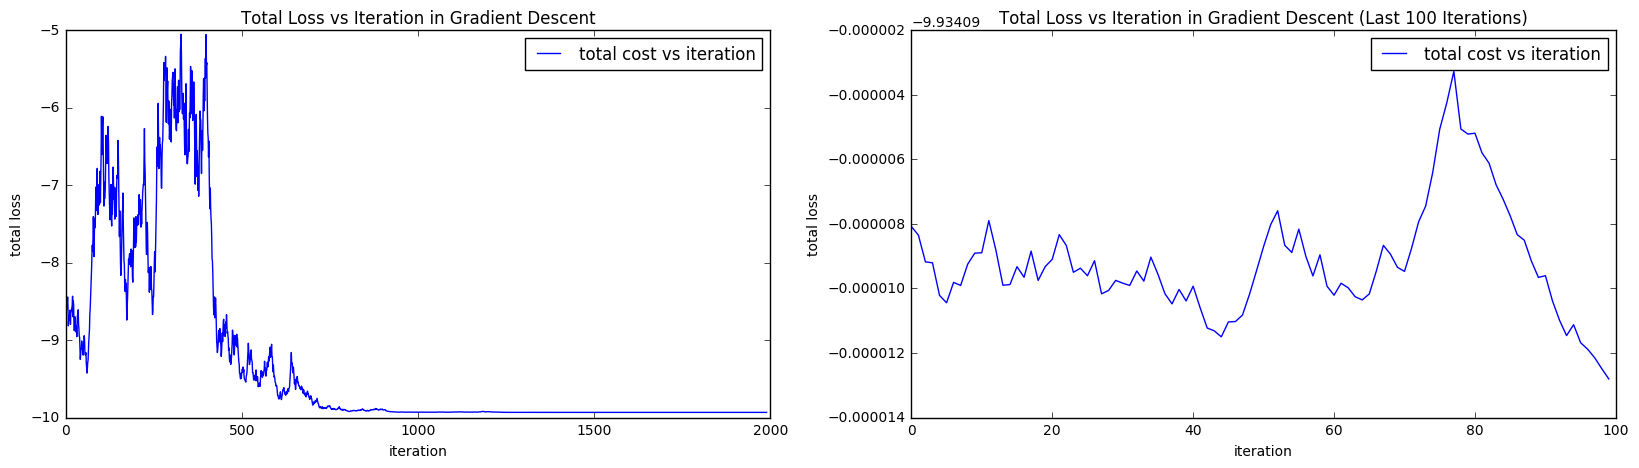

In [116]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=0.001, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'with initial random shuffling'
print '****************************'
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

We see that we are within tolerance of our optimal parameters after 3,894 steps (versus the 43,545 steps it takes gradient descent) in the stochastic gradient descent algorithm. From the visualization of the total loss versus iteration, we see that, with an initial shuffling of the data, the path stochastic gradient descent takes to the optimal solution is even more erratic. We are taking paths along which the total loss rises and drops before finally stabilizing somewhat around the optimal total loss of -9.93410279384. 

When we examing the total colossst for the last 100 iterations, we see that stochastic gradient descent is ocillating around the optimal loss. This behavious can be worrisome if we need to obtain a higher precision solution - it's possible that stochastic gradient descent will never fall within the required tolerance.

### Part B
- Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.
- Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3` (you may wish to set a cap for maximum number of iterations). Which method converges to the optimal point in fewer iterations? Briefly explain why this result should be expected.

**Solution:**

<a id="compare"></a>
### Comparison: Gradient Descent vs Stochastic Gradient Descent

#### Speed:
We see that it takes 0.000573873519897 seconds to compute one gradient for gradient descent, while it takes around 0.000241994857788 seconds to compute one gradient for stochastic gradient descent. This is expected. We expect that computing gradients for gradient descent can take longer, given that we must perform operations on the entire set of data. However, since our dataset is relatively small and our operations (sums) are relatively light weight, the difference between these two gradient computations is minute. 

However, this will not always be the case (i.e. our data will not always be small, and the operations required to compute the gradient will not always be simple)! For example, you can try to perform gradient descent in your Long Form Homework #1 and see how that will change your training time.

So is Stochastic Gradient Descent a faster algorithm? To answer this question rigorously and productively, we must decompose our notion of fast in two ways:

1. the time it takes to compute one gradient
2. the number of steps it takes to converge to an acceptable solution

We've already addressed the difficulty of computing the gradient over the entire dataset - in this case, stochastic gradient descent is the "faster" algorithm. In our case stochastic gradient descent found the global optimum in fewer iterations. However, this is an exception. We can already see, from our visualizations, that stochastic gradient descent can take paths through the parameter space that increases total cost, and it can have oscillating behaviour when it approaches the global optima. In fact, the erratic paths SGD takes can often lead to slow convergence and the algorithm can easily fail to converge at all (i.e. never being able to achieve a certain degree to accuracy). 

#### Sensitivity to Stepsize:
So how does a change in step size affect the performance of stochastic gradient descent? We will run SGD for various stepsize, each time testing the step size with an initial randomization of the data and without.

epoch:  0
****************************
without initial random shuffling
****************************
stepsize:  0.01
time to compute one gradient:  0.000184059143066
how many iters:  3845
final loss: inf
precision to actual param: inf


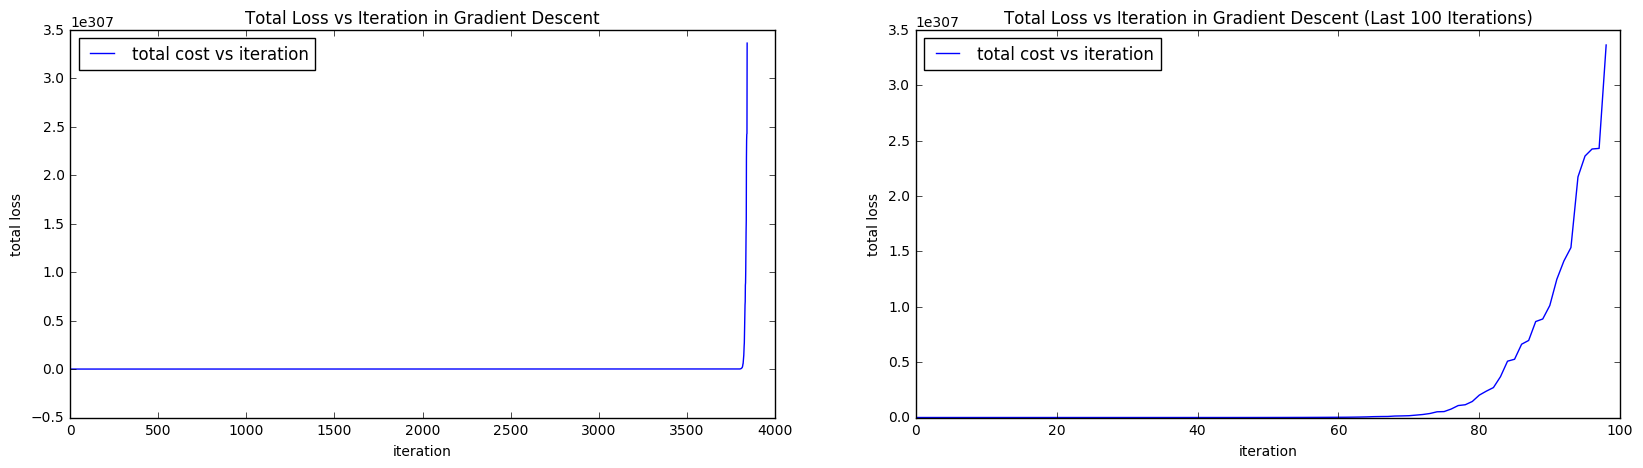

In [134]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.01, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'without initial random shuffling'
print '****************************'
print 'stepsize: ', 0.01
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
with initial random shuffling
****************************
stepsize:  0.01
time to compute one gradient:  0.000180959701538
how many iters:  33
final loss: -9.93410303293
precision to actual param: 0.000636164118328


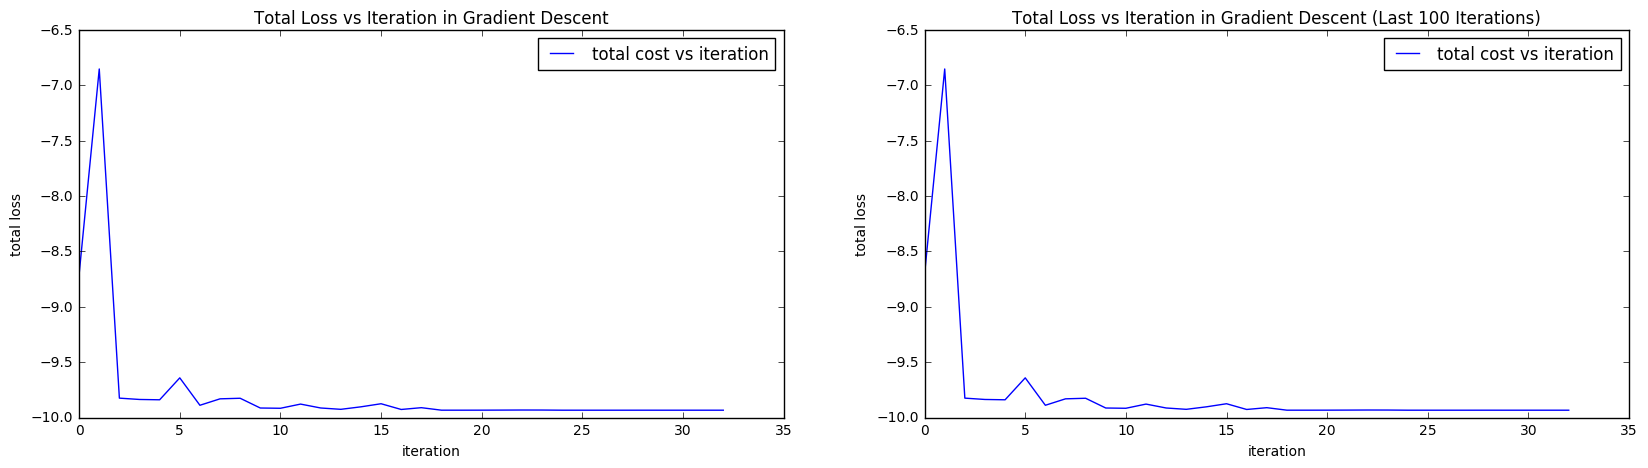

In [136]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=0.01, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'with initial random shuffling'
print '****************************'
print 'stepsize: ', 0.01
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
without initial random shuffling
****************************
stepsize:  0.1
time to compute one gradient:  0.00018310546875
how many iters:  541
final loss: inf
precision to actual param: inf


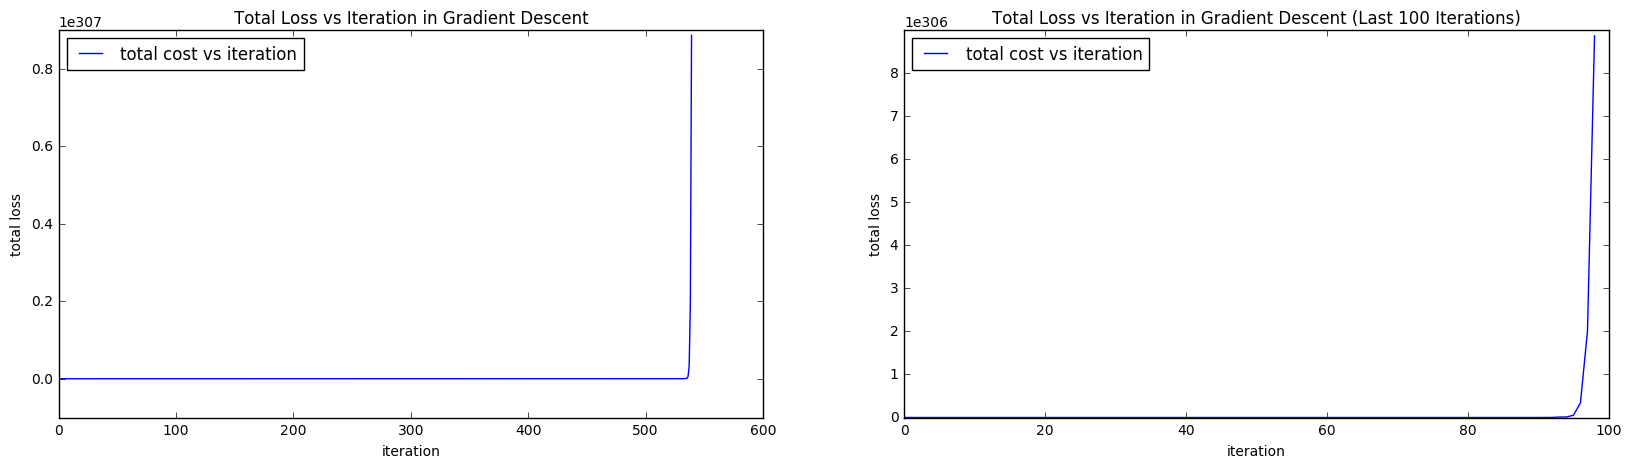

In [137]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=False, step_size=0.1, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'without initial random shuffling'
print '****************************'
print 'stepsize: ', 0.1
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
epoch:  1
epoch:  2
epoch:  3
****************************
with initial random shuffling
****************************
stepsize:  0.1
time to compute one gradient:  0.00019097328186
how many iters:  59412
final loss: -9.93410388504
precision to actual param: 0.000226948870237


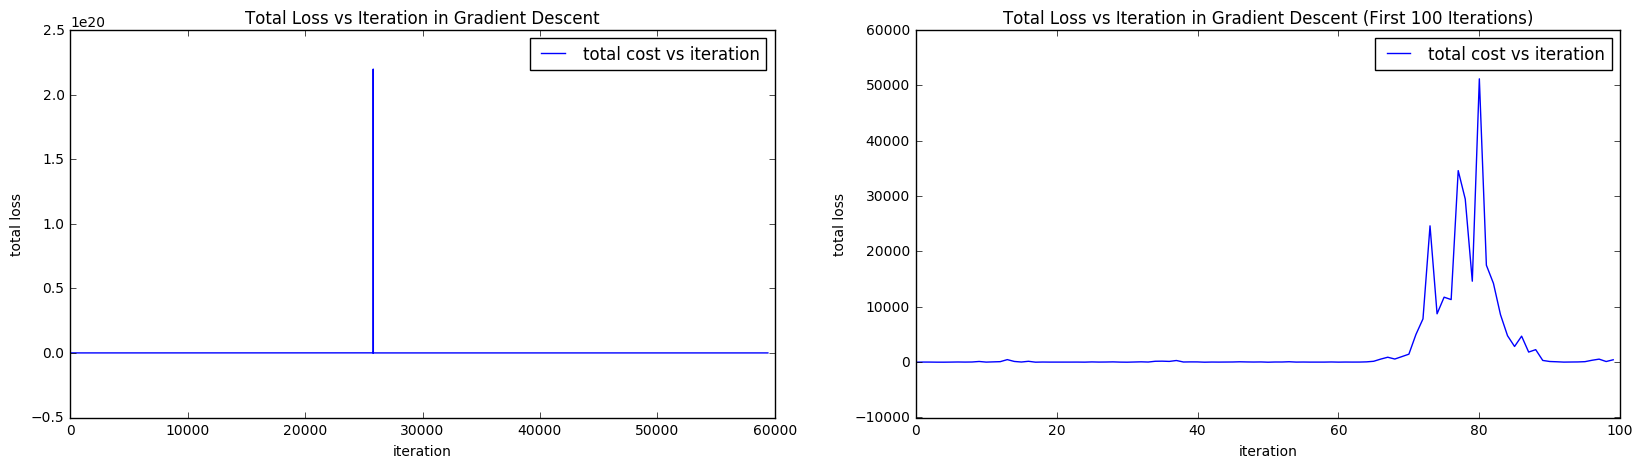

In [140]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=0.1, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'with initial random shuffling'
print '****************************'
print 'stepsize: ', 0.1
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[:100])), costs[:100], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (First 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
without initial random shuffling
****************************
stepsize:  1
time to compute one gradient:  0.000195980072021
how many iters:  163
final loss: inf
precision to actual param: inf


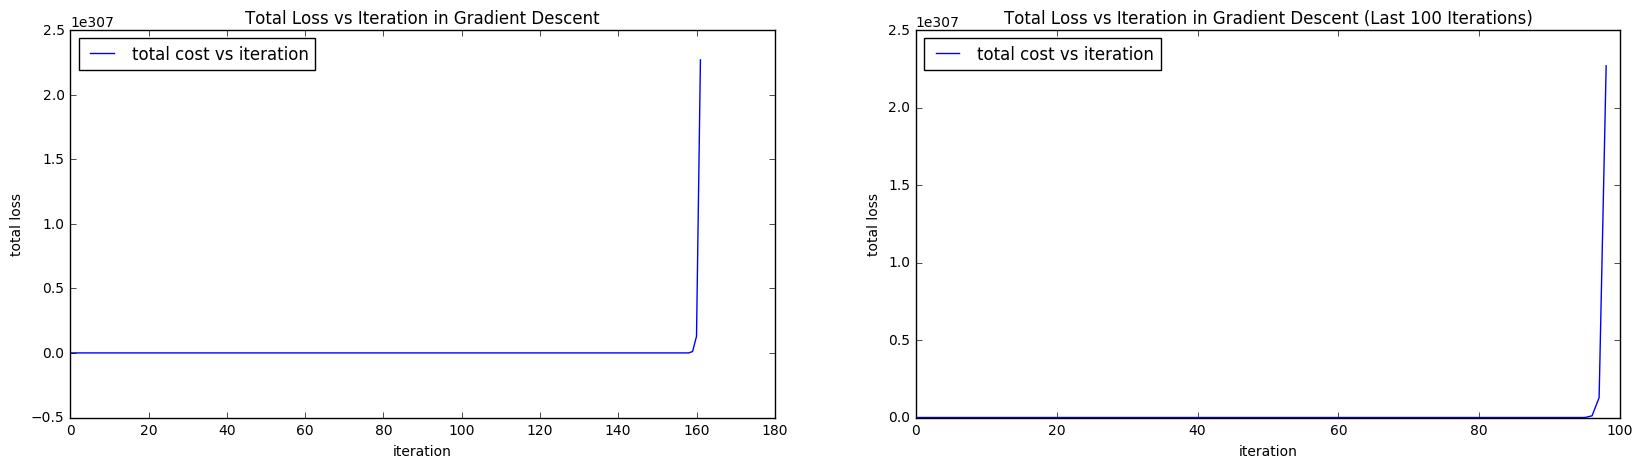

In [141]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=False, step_size=1, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'without initial random shuffling'
print '****************************'
print 'stepsize: ', 1
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:])), costs[-100:], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

epoch:  0
****************************
with initial random shuffling
****************************
stepsize:  1
time to compute one gradient:  0.000306129455566
how many iters:  182
final loss: inf
precision to actual param: inf


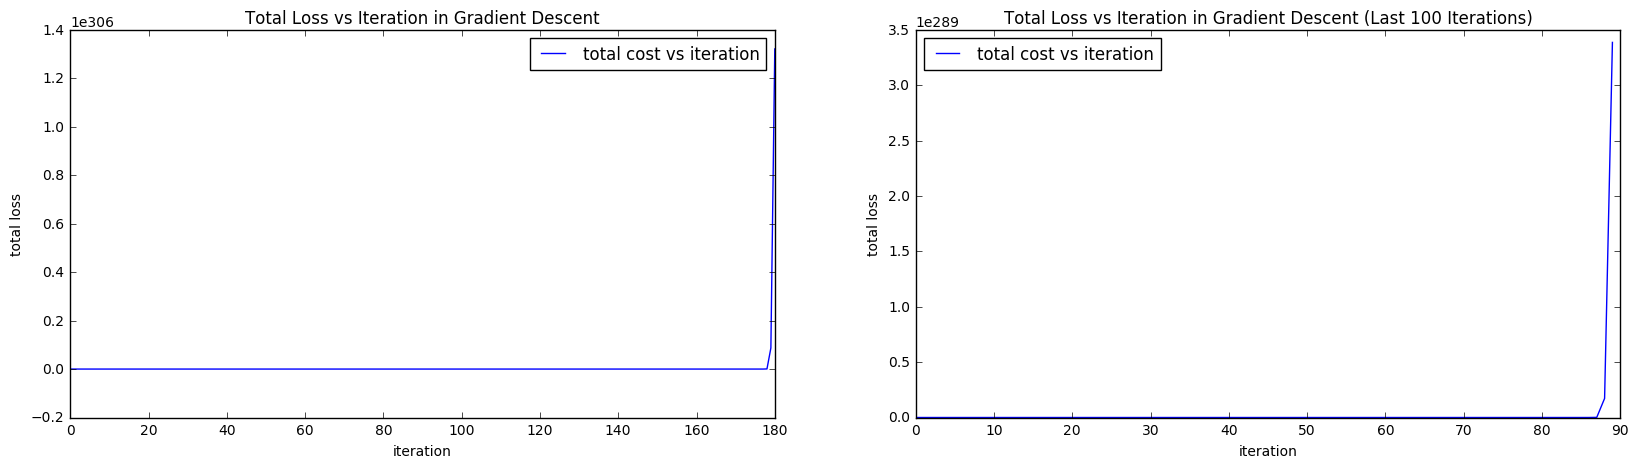

In [142]:
lambdas_init = [2, -1]
start = time.time()
grad(lambdas_init[0], lambdas_init[1], x[0], y[0])
end = time.time() 

history, epoch = sgd(x, y, lambdas_init, init_shuffle=True, step_size=1, max_epochs=8, scaling=1000.)
history = np.array(history)

lambdas = history[-1]
costs = L(history[:, 0], history[:, 1], x, y)
print '****************************'
print 'with initial random shuffling'
print '****************************'
print 'stepsize: ', 1
print 'time to compute one gradient: ', end - start
print 'how many iters: ', len(history)
print 'final loss:', costs[-1]
print 'precision to actual param:', np.linalg.norm(lambdas - [2.05384, 0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(len(costs)), costs, label='total cost vs iteration')
ax1.set_xlabel('iteration')
ax1.set_ylabel('total loss')
ax1.set_title('Total Loss vs Iteration in Gradient Descent')
ax1.legend(loc='best')

ax2.plot(range(len(costs[-100:-10])), costs[-100:-10], label='total cost vs iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('total loss')
ax2.set_title('Total Loss vs Iteration in Gradient Descent (Last 100 Iterations)')
ax2.legend(loc='best')
plt.show()

We see that if we don't shuffle the data initially, for step sizes 0.01 through 1, the stochastic gradient descent will follow a path heading away from the global optimum (increases the total loss along the path). Let this be a warning to us all: for some permutations of your data, your stochastic gradient descent can head away from your optimal solution and never return!

When we shuffle the data before beginning descent, we see that a step size of 0.01 sped up the convergence of SGD. That is, our algorithm converged upon the optimal solution in a mere 33 steps. This makes intuitive sense, the bigger your steps, the faster you reach your goal.

However, when the step size increased to 0.1, the algorithm now takes ***longer*** to converge (it required 59,412 iterations). Perhaps this is surprising to us. However, if we look once again at the path stochastic gradient descent takes through the parameter space, we can see the reason for the slow-down. Since SGD appears to read the global minimum by first climbing "up hill" (going in a direction that increases the total loss). Taking bigger steps here also means traveling further away from the goal and amplifying your errors in approximating the "true" gradient.

Finally, when the step size increases to 1. The total cost along the path that SGD takes in the parameter space is so large that it exceed machine precision.